In [1]:
%load_ext autoreload
%autoreload 2
    
import tme9

# TME 9 : méthodes discriminatives

**Le but de ce TME est d'implémenter des méthodes discriminatives en classification. On s'intéressera en particulier au modèle de régression logistique.**

***Rappel sur les approches discriminantes :***<BR>
**Nous notons  les observations $\mathbf x_i \in \mathbb R^d$ et nous allons mettre en place des modèles de classification binaire dans un premier temps.** Dans ce contexte, les étiquettes binaires associées sont $y_{i} \in \mathcal Y = \{0; 1\}$.
Nous faisons l'hypothèse que les couples $(\mathbf x_i, y_{i})$ sont tirés de manière i.i.d. et suivent une loi inconnue $P(X,Y)$. 

**Dans les méthodes discriminatives, on s'intéresse à estimer la loi conditionnelle $p(y_i | \mathbf x_i, \boldsymbol{\theta})$.**
    
1. Choix d'un modèle pour $p(y_i | \mathbf x_i,\boldsymbol{\theta})$. Le modèle le plus connu est la régression logistique qui, comme le nom ne l'indique pas est un modèle de classification. C'est ce modèle que nous allons étudier, qui utilise un modèle linéaire, de paramètres $\boldsymbol{\theta}:=(\mathbf{w},b)$ :
 \begin{equation}
    \label{eq:binary_lr}
    p(y_i=1 | \mathbf x_i,\mathbf{w},b) = \frac{1}{1 + \exp( -(  \mathbf x_i  \mathbf w + b))} 
\end{equation}    
    
1. Dans le cas à deux classes uniquement; après avoir remarqué que nous avons choisi un codage des classes de type Bernoulli... Utilisation de l'astuce de Bernoulli pour calculer la vraisemblance d'un échantillon:
$$ p(y_i | \mathbf x_i,\mathbf{w},b) = \left( \frac{1}{1 + \exp( -(  \mathbf x_i  \mathbf w + b))}\right)^{y_i} \left(1- \frac{1}{1 + \exp( -(  \mathbf x_i  \mathbf w + b))}\right)^{1-y_i}$$ <BR>
    
1. Max de vraisemblance sur ***sur l'ensemble des données d'apprentissage $(\mathbf{x_i}, y_{i})_{i \in \left\{1;N\right\}}$*** :<BR><BR>
    $$\mathbf w^\star, b^\star = \arg \max_{\mathbf w, b} \prod_{i=1}^N p(\mathbf y_i | x_i \mathbf w, b)$$
    

## Chargement des librairies et des données USPS

Taille des données train=( 6229 , 256 )
Taille des données test=( 3069 , 256 )


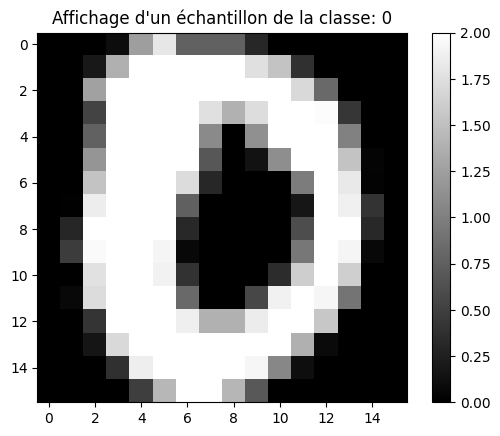

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle as pkl

data = pkl.load(open("res/usps.pkl",'rb')) 
# data est un dictionnaire contenant les champs explicites X_train, X_test, Y_train, Y_test
X = np.array(data["X_train"],dtype=float) # changement de type pour éviter les problèmes d'affichage
Xt = np.array(data["X_test"],dtype=float)
Y = data["Y_train"]
Yt = data["Y_test"]

print("Taille des données train=(",X.shape[0],",",X.shape[1],")")
print("Taille des données test=(",Xt.shape[0],",",Xt.shape[1],")")

# affichage d'un échantillon
index = 0
plt.figure()
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))
plt.imshow(X[index].reshape(16,16), interpolation=None, cmap='gray')
plt.colorbar() 

# Exercice 1: régression logistique binaire

***Rappel: régression logistique = système de classification***

$$ p(y_i | \mathbf x_i, \mathbf{w}, b) = \left( \frac{1}{1 + \exp( -(  \mathbf x_i  \mathbf w + b))}\right)^{y_i} \left(1- \frac{1}{1 + \exp( -(  \mathbf x_i  \mathbf w + b))}\right)^{1-y_i} $$


Soit en agrégeant sur la base de données et notant: $exp = \exp( -(  \mathbf x_i  \mathbf w + b))$
$$\mathcal L_{log} = CE(\mathbf{w}, b)= \sum_i  y_i \log(\frac{1}{1+exp}) + (1-y_i) \log(1-\frac{1}{1+exp})$$ 
$$CE(\mathbf{w}, b)=\sum_{i=1}^N \log(1+exp) ( -y_i -1 + y_i) + \log(exp)(1-y_i)$$

Soit:
$$ \frac{\partial  }{\partial w_j} CE=\sum_{i=1}^N x_{ij}( y_i-\frac{1}{1+exp}) \in \mathbb R$$
On remarque qu'il est possible de passer à une écriture vectorielle:
$$ \nabla_{\mathbf w} CE =X^T ( Y-\frac{1}{1+\exp( -(  \mathbf X  \mathbf w + b))}) \in \mathbb R^d$$
$$ \frac{\partial  }{\partial b} CE =\sum_{i=1}^N ( y_i-\frac{1}{1+exp}) \in \mathbb R$$

$\underline{\textbf{Note:}}$ il est possible de manière **facultative**, comme dans le TME de la semaine dernière, de construire:
$$Xe = \left[\begin{array}{cc}
                \mathbf x_0 & 1\\
                \vdots & \vdots\\
                \mathbf x_N & 1
                \end{array}
                \right] $$
On supprime alors les $b$ pour obtenir:
$$ \nabla_{\mathbf w_e} CE(\mathbf{w}, b) =X_e^T ( Y-\frac{1}{1+\exp( -(  \mathbf X_e  \mathbf w_e))}) \in \mathbb R^{d+1}$$

### Mise en place de la montée de gradient pour la régression logistique binaire
- Initialisation des paramètres : $\mathbf{w} \leftarrow \mathbf{w}^0$, $b \leftarrow b^0$
- Pour $t=1$ à $T$ 
    - $\mathbf{w}_{t+1} \leftarrow \mathbf{w}_{t} + \eta \nabla_w CE(\mathbf{w}_t)$, $b_{t+1} \leftarrow b_{t} + \eta  \frac{\partial  }{\partial b} CE(b_t)$ 

**Nous commençons par la tester sur les données de la classe 0.** On transforme les labels de classes $\in \{1; K\}$ vers $\{0; 1\}$ pour la classe 0.

In [3]:
# 0 vs all
cl = 0
Y_c  = tme9.labels_tobinary(Y, cl) 
Yt_c = tme9.labels_tobinary(Yt, cl) 
#print("Taille des données :",X.shape,Y_c.shape)

**Fonction de prédiction avec la régression logistique binaire**

In [4]:
# Fonction de prédiction pour la régression logistique
Y_pred  = tme9.pred_lr(X, np.zeros(256),0)
print(Y_pred[0:10])
Yt_pred = tme9.pred_lr(Xt, np.zeros(256),0)
print(Yt_pred[0:10])

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


In [5]:
Y_predb  = tme9.classify_binary(Y_pred)
Yt_predb = tme9.classify_binary(Yt_pred)
print(Yt_predb[0:10])
print(Yt_c[0:10])

[0 0 0 0 0 0 0 0 0 0]
[0 1 1 0 0 0 1 0 0 0]


In [6]:
# Fonction pour calculer l'accuracy
acc  = tme9.accuracy(Y_predb, Y_c)
acct = tme9.accuracy(Yt_predb,Yt_c)
print("Tx de bonne classification en Apprentissage={0:.2f} %".format(acc*100))
print("Tx de bonne classification en Test={0:.2f} %".format(acct*100))

Tx de bonne classification en Apprentissage=82.90 %
Tx de bonne classification en Test=84.10 %


**Mettre en place la méthde `rl_gradient`(X,Y,eta, nMax) pour apprendre la régression logistique par montée de gradient. Nous commençons par la tester sur les données de la classe 0**

[0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0] 
 [0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0]
Tx de bonne classification en Apprentissage= 0.9911703323165837
Tx de bonne classification en Test= 0.9869664385793419


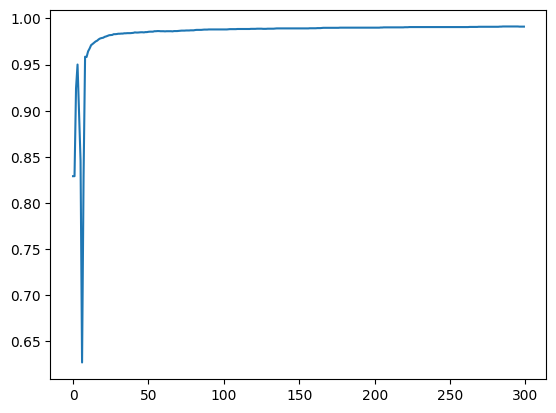

In [7]:
# application de la montée de gradient & evaluation des performances
w,b, accs, it = tme9.rl_gradient_ascent(X,Y_c,eta = 1e-4, niter_max=300)
#w,b, acc, acct, it = rl_gradient(X,Y_c, Xt, Yt_c, epsilon = 1e-4)

Y_predb  = tme9.classify_binary(tme9.pred_lr(X, w,b))
Yt_predb = tme9.classify_binary(tme9.pred_lr(Xt, w,b))

# affichage des 20 premières étiquettes
print(Yt_c[:20],"\n",Yt_predb[:20]) # vérifier que les données sont dasn le même univers

# perf:
acc  = tme9.accuracy(Y_predb,Y_c)
acct = tme9.accuracy(Yt_predb,Yt_c)

#pc_good   = np.where(Y_pred == Y_c , 1., 0.).mean()
#pc_good_t = np.where(Yt_pred==Yt_c , 1., 0.).mean()

print("Tx de bonne classification en Apprentissage=",acc)
print("Tx de bonne classification en Test=",acct)
#it = 8
plt.figure()
plt.plot(np.arange(it), accs[0:it])
#plt.figure()
#plt.plot(np.arange(it), acct[0:it])

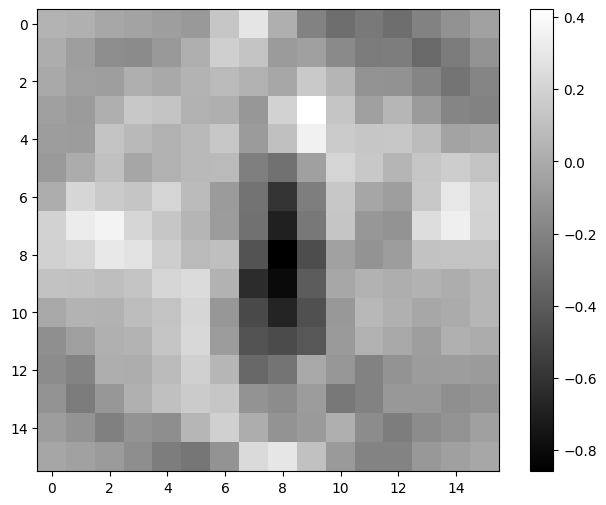

In [8]:
# Visualisation du vecteur de poids w
tme9.visualization(w)

# Exercice 2 :  passage au multiclasse (1 contre tous)

Nous allons utiliser le paradigme *un-contre-tous* mais nous allons le coder proprement dans une fonction.
Dans la fonction ```rl_multi(X,Y, epsilon = 1e-3, niter_max=1000)``` effectuer les opérations suivantes:

1. Extraire toutes les classes de Y
1. Pour chaque classe
11. Construire Ycl telle que:
$$Y_{cl} = \left\{ 
\begin{array}{cl}
1 & \mbox{ si } Y == cl     \\
0 & \mbox{ sinon (pour toutes les autres classes) }
\end{array}
\right.$$
11. Lancer un apprentissage
1. Empiler tous les $\mathbf w$ & $b$ comme suit:

$$W = \left[\begin{array}{cccc}
                \\
                \mathbf w_{cl=0} & \mathbf w_{cl=1} & \ldots & \mathbf w_{cl=9}
                \\ \\
                \end{array}
                \right] $$
$$\mathbf b = \left[\begin{array}{cccc}
                \mathbf b_{cl=0} & \mathbf b_{cl=1} & \ldots & \mathbf b_{cl=9}
                \end{array}
                \right] $$
                
On peut alors montrer que:
$$ \frac{1}{1+\exp( - \mathbf X W - \mathbf b)}  = \left[\begin{array}{cccc}
                p(Y = 1 | X = \mathbf x_1) & p(Y = 2 | X = \mathbf x_1) & \ldots & p(Y = 9 | X = \mathbf x_1)
                \\ 
                \vdots & &\ddots & \vdots\\
p(Y = 1 | X = \mathbf x_N) & p(Y = 2 | X = \mathbf x_N) & \ldots & p(Y = 9 | X = \mathbf x_N)
\\
                \end{array}
                \right] \in \mathbb R^{N\times C}$$
               Avec $N$ points et $C$ classes
1. Utiliser un ```argmax``` pour extraire le numéro de classe

In [9]:
# duree execution = 30 secondes à une minute
# n'hésitez pas à mettre un niter_max à 10 durant la phase de debug pour gagner du temps !
W,B = tme9.rl_gradient_ascent_one_against_all(X,Y,epsilon = 1e-4, niter_max=1000)
#print(B)

Classe : 0 acc train=99.42 %
Classe : 1 acc train=99.78 %
Classe : 2 acc train=98.81 %
Classe : 3 acc train=98.89 %
Classe : 4 acc train=98.76 %
Classe : 5 acc train=98.81 %
Classe : 6 acc train=99.41 %
Classe : 7 acc train=99.61 %
Classe : 8 acc train=97.98 %
Classe : 9 acc train=98.47 %


### Evaluation des performances 

In [10]:
# perf:
Y_pred  = tme9.pred_lr(X, W,B)
Y_predt = tme9.pred_lr(Xt, W,B)
# print(Yt[:20],"\n",Yt_pred[:20])
Y_pred_mc  = tme9.classif_multi_class(Y_pred)
Yt_pred_mc = tme9.classif_multi_class(Y_predt)

acc  = tme9.accuracy(Y_pred_mc,Y)
acct = tme9.accuracy(Yt_pred_mc,Yt)

print("Tx de bonne classification en Apprentissage={0:.2f} %".format(acc*100))
print("Tx de bonne classification en Test={0:.2f} %".format(acct*100))

Tx de bonne classification en Apprentissage=96.68 %
Tx de bonne classification en Test=93.58 %


# Exercice 3 : Analyse qualitative des solutions

Quels sont les pixels qui jouent un role dans la décision?

1. Pour une classe de données, je peux déjà afficher l'ampleur des poids $\mathbf w$ associés à chaque classe. Cela indique si les pixels sont pondérés positivement ou négativement.
1. Pour une image donnée, je sais que la décision est de la forme:
$$p(y_i=1 | \mathbf x_i) = \frac{1}{1 + \exp( -(  \mathbf x_i  \mathbf w + b))}$$
Ainsi, la décision est formée d'une addition de $x_{ij}\cdot w_j$: les plus fortes composante en valeur absolue sont celles qui participent le plus à la décision. <BR>
Cette approche est particulièrement intéressante pour analyser les erreurs de classification.
Afficher l'image d'un chiffre mal classé et une carte de chaleur indiquant quelles parties de l'image influencent le plus la décision: pour la classe prédite d'une part et pour la classe réelle d'autre part.

<Figure size 640x480 with 0 Axes>

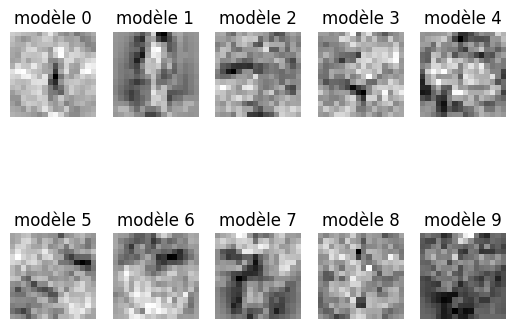

In [11]:
# affichage des poids des paramètres des 10 classes (PAS DE CODE A AJOUTER)
# prérequis: que les w soit en colonnes dans la matrice W
plt.figure()
plt.subplots(2, 5)
for i in range(10):
    plt.subplot(2, 5,i+1)
    plt.imshow(W[:,i].reshape(16,16), cmap="gray")
    plt.title("modèle "+str(i))
    plt.axis('off')

60


<Figure size 640x480 with 0 Axes>

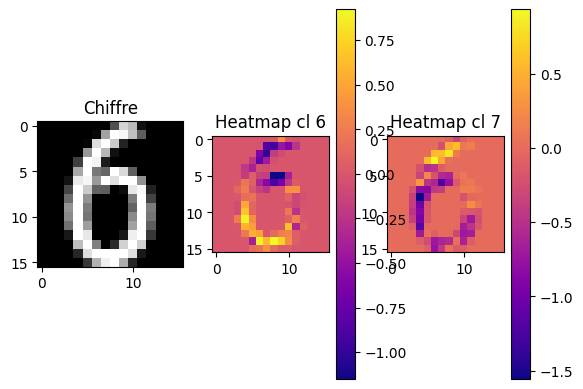

In [12]:
# trouver un échantillon mal classé (PAS DE CODE A AJOUTER):

index = np.where(Y != Y_pred_mc)[0][0] # parmi les points d'apprentissage
print(index)

plt.figure()
plt.subplots(1,3)
plt.subplot(1,3,1)
plt.imshow(X[index].reshape(16,16),cmap="gray")
plt.title("Chiffre")
plt.subplot(1,3,2)
plt.imshow((X[index]*W[:,int(Y[index])]).reshape(16,16),cmap="plasma")
plt.colorbar()
plt.title("Heatmap cl "+str(int(Y[index])))
plt.subplot(1,3,3)
plt.imshow((X[index]*W[:,int(Yt_pred_mc[index])]).reshape(16,16),cmap="plasma")
plt.title("Heatmap cl "+str(int(Yt_pred_mc[index])))
plt.colorbar()
plt.savefig("malclasse.png")


**Quelle limitation sur l'encodage des pixels noirs (à 0) cette visualisation met-elle en évidence ? Expliquer.**

# Exercice 4 : Normalisation des données X

**On va effectuer la normalisation suivante : $X_n = X-1$ (les valeurs de pixels étant entre $0$ et $2$).** 
**Expliquer en quoi cette normalisation résoud le problème précédent.**

Ecrire la fonction pour `normalize(X)`.


In [13]:
Xn  = tme9.normalize(X)
Xtn = tme9.normalize(Xt)

On peut ensuite appliquer sans modification la fonction précédente :

In [14]:
# il n'y a pas de méthode à redéfinir...
# juste apprendre un nouveau modèle sur des données modifiées... Et ne pas faire d'erreur en inférence.
Wn,Bn = tme9.rl_gradient_ascent_one_against_all(Xn,Y,epsilon = 1e-4, niter_max=1000)

# perf:
Y_pred  = tme9.pred_lr(Xn, Wn,Bn)
Y_predt = tme9.pred_lr(Xtn, Wn,Bn)
# print(Yt[:20],"\n",Yt_pred[:20])
Y_pred_mc  = tme9.classif_multi_class(Y_pred)
Yt_pred_mc = tme9.classif_multi_class(Y_predt)

acc  = tme9.accuracy(Y_pred_mc,Y)
acct = tme9.accuracy(Yt_pred_mc,Yt)

print("Tx de bonne classification en Apprentissage={0:.2f} %".format(acc*100))
print("Tx de bonne classification en Test={0:.2f} %".format(acct*100))

Classe : 0 acc train=99.47 %
Classe : 1 acc train=99.73 %
Classe : 2 acc train=98.76 %
Classe : 3 acc train=98.88 %
Classe : 4 acc train=98.67 %
Classe : 5 acc train=98.70 %
Classe : 6 acc train=99.53 %
Classe : 7 acc train=99.61 %
Classe : 8 acc train=98.25 %
Classe : 9 acc train=98.44 %
Tx de bonne classification en Apprentissage=96.56 %
Tx de bonne classification en Test=93.71 %


91


<Figure size 640x480 with 0 Axes>

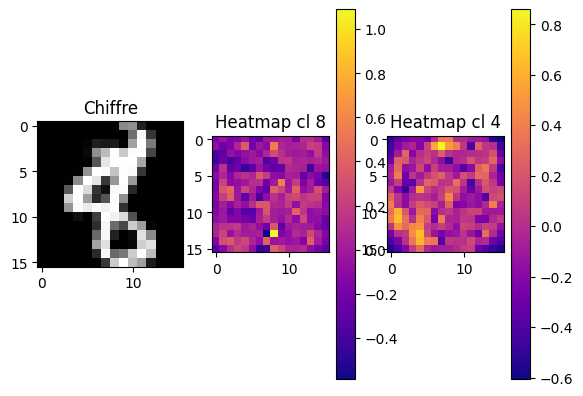

In [15]:
# trouver un échantillon mal classé (PAS DE CODE A AJOUTER):

index = np.where(Y != Y_pred_mc)[0][0] # parmi les points d'apprentissage
print(index)

plt.figure()
plt.subplots(1,3)
plt.subplot(1,3,1)
plt.imshow(X[index].reshape(16,16),cmap="gray")
plt.title("Chiffre")
plt.subplot(1,3,2)
plt.imshow(((X[index]-1)*Wn[:,int(Y[index])]).reshape(16,16),cmap="plasma")
plt.colorbar()
plt.title("Heatmap cl "+str(int(Y[index])))
plt.subplot(1,3,3)
plt.imshow(((X[index]-1)*Wn[:,int(Y_pred_mc[index])]).reshape(16,16),cmap="plasma")
plt.title("Heatmap cl "+str(int(Y_pred_mc[index])))
plt.colorbar()

# Exercice 5 : Régression logistique multi-classe

Le modèle de régression logistique correspond à un réseau de neurones à une seule couche, qui va projeter le vecteur d’entrée $ \mathbf{x_i} \in \mathbb{R}^d$ vers un vecteur $\boldsymbol{s} \in \mathbb{R}^K$ ($K$ est le nombre de classes), consistant en une projection affine puis l'application de la fonction softmax : 

- Projection affine : $\boldsymbol{s}= \boldsymbol{x}\boldsymbol{W}+\boldsymbol{b}$, où $\boldsymbol{W}$ est de taille $d\times K$ et $\boldsymbol{b}$ de taille $1\times K$. 

- Softmax pour avoir un vecteur de probabilité pour la sortie $\boldsymbol{\hat{y}} \in \mathbb{R}^K$, dont la prédiction pour la $k^{\grave{e}me}$ classe s'écrit : 
$\hat{y}_k = \frac{e^{s_k}}{\sum\limits_{j=0}^K e^{s_j}}$

Le schéma ci-dessous illustre le modèle de régression logistique avec un réseau de neurones.


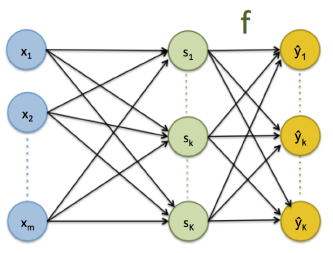

#### Ecrire la fonction `pred_lr_multi_class` pour effectuer la prédiction multi-classe

In [16]:
# Prédiction pour la régression logistique multi-classe
Y_pred  = tme9.pred_lr_multi_class(X, np.zeros((256,10)), np.zeros(10))
print(Y_pred[0])
Yt_pred = tme9.pred_lr_multi_class(Xt, np.zeros((256,10)), np.zeros(10))
print(Yt_pred[0])

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


**Les labels prédits utiliseront la même fonction que dans le cas un contre tous, ainsi que l'accuracy : **

In [17]:
# Prédiction de classe par le modèle
Y_predc  = tme9.classif_multi_class(Y_pred)
Yt_predc = tme9.classif_multi_class(Yt_pred)
print(Yt_predc[0:10])
print(Yt[0:10])

acc  = tme9.accuracy(Y_predc, Y)
acct = tme9.accuracy(Yt_predc,Yt)
print("Tx de bonne classification en Apprentissage={0:.2f} %".format(acc*100))
print("Tx de bonne classification en Test={0:.2f} %".format(acct*100))

[0 0 0 0 0 0 0 0 0 0]
[2 0 0 2 7 6 0 6 1 9]
Tx de bonne classification en Apprentissage=17.10 %
Tx de bonne classification en Test=15.90 %


## 5.2 Entraînement de la régression logistique multi-classe


Pour entraîner le modèle, la première étape consiste à transformer labels $Y$ (taille $N$) en une matrice $Y_c$ de taille $N \times K$ correspondant au "one-hot-encoding" de la classe, *i.e.* chaque ligne de $Y_c$ est un vecteur binaire avec des $0$ partout sauf pour l'indice de la classe donnée par la supervision, par laquelle la valeur est à 1.

**Ecrire la fonction `to_categorical(Y,K)` qui va effectuer cette transformation** 

In [18]:
K=10
Yc = tme9.to_categorical(Y, K)
Yct = tme9.to_categorical(Yt, K)
print(Y[0:2])
print(Yc[0:2])

[0 9]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


**Pour entraîner le modèle on va, pour chaque exemple d'entraînement $\boldsymbol{x}_i$, maximiser la log probabilité de la prédiction du modèle pour la classe donnée par la supervision**, *i.e.* $\hat{y}_i^{k_*}$. La log propabilité pour le dataset complet va donc s'écrire : 

$$\mathcal{L}_{CEx} = \frac{1}{N}\sum_{i=1}^N log(\hat{y}_i^{k_*})$$


**On va ensuite entraîner le modèle de prédiction multi-classe en utilisant une montée de gradient.**
On rappelle les équations du gradient vues en cours : 

- $\frac{\partial \mathcal{L}_{CEx}}{\partial \boldsymbol{W}} = \frac{1}{N}\boldsymbol{X}^T (\boldsymbol{Y}_c - \hat{\boldsymbol{Y}})$, avec $\boldsymbol{X}$ la matrice des données (taille $N \times d$), $\hat{\boldsymbol{Y}}$ la matrice des prédiction du modèle (taille $N \times K$), et $\boldsymbol{Y}_c$ l'encodage one-hot des classes de la supervision (taille $N \times K$).
-$\frac{\partial \mathcal{L}_{CEx}}{\partial \boldsymbol{b}} = \frac{1}{N}\sum\limits_{i=1}^N(\boldsymbol{Y}_c - \hat{\boldsymbol{Y}})$

**Ecrire la fonction `rl_gradient_ascent_multi_class` qui effectue l'entraînement de la régression logistique par montée de gradient**. On passera à la fonction les classes originales $Y$, qu'on transformera dans la fonction en encode one-hot, et qu'on utilisera pour calculer l'accuracy.

In [19]:
W,b = tme9.rl_gradient_ascent_multi_class(X,Y, eta=0.2, numEp = 1000, verbose=1)
acct = tme9.accuracy(tme9.classif_multi_class(tme9.pred_lr_multi_class(Xt, W,b)),Yt)
print("Tx de bonne classification en Test={0:.2f} %".format(acct*100))

epoch 0 accuracy train=17.10 %
epoch 100 accuracy train=93.80 %
epoch 200 accuracy train=94.80 %
epoch 300 accuracy train=95.28 %
epoch 400 accuracy train=95.52 %
epoch 500 accuracy train=95.76 %
epoch 600 accuracy train=95.99 %
epoch 700 accuracy train=96.16 %
epoch 800 accuracy train=96.32 %
epoch 900 accuracy train=96.47 %
epoch 999 accuracy train=96.64 %
Tx de bonne classification en Test=94.04 %


**On va maintenant passer à une descente de gradient stochastique**, qui va calculer le gradient sous un sous-ensemble d'exemples. Par exemple, pour un batch de taille $500$, on va avoir 13 mises à jour par époque au lieu d'une avec la descente standard. Ceci va permettre de faire converger l'algorithme avec moins d'époques.
**Adapter la fonction précédente dans la fonction `rl_gradient_ascent_multi_class_batch`** pour effectuer la descente de gradient stochastique.

In [20]:
W,b = tme9.rl_gradient_ascent_multi_class_batch(X,Y, tbatch = 500, eta=0.2, numEp = 200, verbose=1)
acct = tme9.accuracy(tme9.classif_multi_class(tme9.pred_lr_multi_class(Xt, W,b)),Yt)
print("Tx de bonne classification en Test={0:.2f} %".format(acct*100))

epoch 0 accuracy train=88.84 %
epoch 20 accuracy train=95.17 %
epoch 40 accuracy train=95.84 %
epoch 60 accuracy train=96.40 %
epoch 80 accuracy train=96.76 %
epoch 100 accuracy train=96.79 %
epoch 120 accuracy train=96.97 %
epoch 140 accuracy train=97.13 %
epoch 160 accuracy train=97.32 %
epoch 180 accuracy train=97.54 %
epoch 199 accuracy train=97.51 %
Tx de bonne classification en Test=94.10 %


# Exercice 6 : régularisation (bonus)

## 6.1 Malédiction de la dimensionnalité 
Nous vous proposons ici de modifier les données pour ajouter des colonnes de bruit. Montrer que la performances se réduit lorsque l'on augmente le nombre de dimensions fantomes.

- La fonction d'ajout des données fantomes `add_random_column` est fournie ci-dessous.
- faites la boucle avec des ajouts de $[0,100,200,400, 1000]$ colonnes et tracer l'évolution des performances en apprentissage et en test.
    - Attention: il faut donc modifier $X$ et $Xt$ avec le même nombre de colonne fantome

**Note :** C'est dans ce cas de figure -qui correspond à beaucoup d'applications réelles- que la régularisation va aider.


In [21]:
# On ajoute du bruit (et on enlève 1) 
# ATTENTION : ne pas enlever une seconde fois 1 ensuite !
def add_random_column(X,d, sig = 1.):
    return np.hstack((X, np.random.randn(len(X),d)*sig))

=== DIMENSIONALITÉ FANTÔME - SANS RÉGULARISATION ===
Noise 0 ‑ Tx de bonne classification en App = 97.54 %
Noise 0 ‑ Tx de bonne classification en Test = 93.94 %
Noise 100 ‑ Tx de bonne classification en App = 99.23 %
Noise 100 ‑ Tx de bonne classification en Test = 91.85 %
Noise 200 ‑ Tx de bonne classification en App = 99.92 %
Noise 200 ‑ Tx de bonne classification en Test = 91.30 %
Noise 400 ‑ Tx de bonne classification en App = 100.00 %
Noise 400 ‑ Tx de bonne classification en Test = 89.31 %
Noise 1000 ‑ Tx de bonne classification en App = 100.00 %
Noise 1000 ‑ Tx de bonne classification en Test = 88.50 %


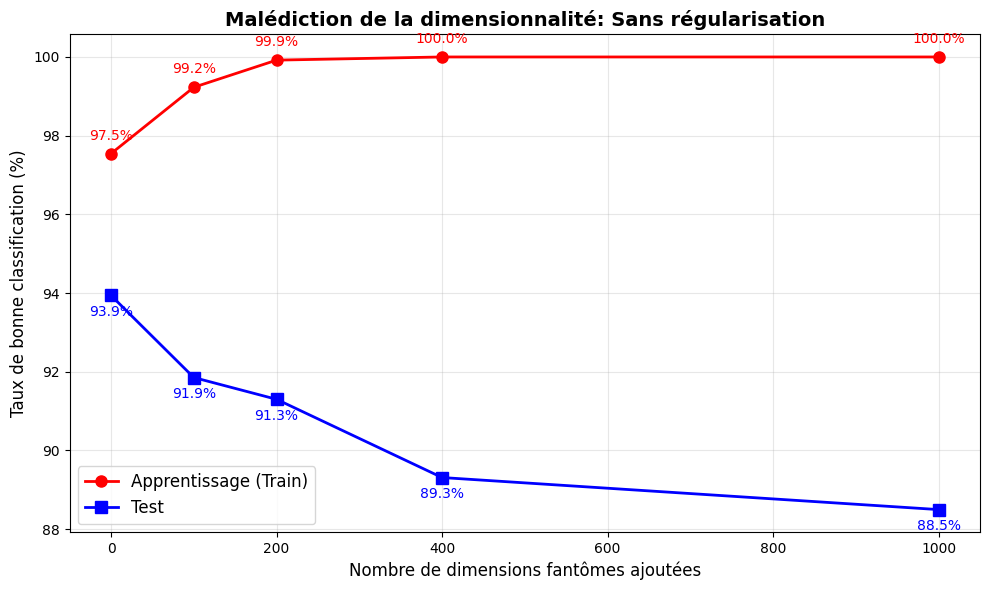

([np.float64(97.54374698988602),
  np.float64(99.2294108203564),
  np.float64(99.91973029378713),
  np.float64(100.0),
  np.float64(100.0)],
 [np.float64(93.93939393939394),
  np.float64(91.85402411208862),
  np.float64(91.30009775171065),
  np.float64(89.31247963506028),
  np.float64(88.49788204626914)])

In [22]:
tme9.dimensionality_curse(X,Y, Xt, Yt)

## 6.2: Régularisation, performance & interprétation

Lorsque la dimension augmente, nous voyons appraître le phénomène de sur-apprentissage.

On fait souvent l'hypothèse que ce phénomène est lié à un estimateur trop complexe. Afin de simplifier la fonction de coût, on proposer de régulariser le problème d'apprentissage qui devient:

$$\arg\max_\theta  \mathcal L - \lambda \Omega(\theta), \qquad \mbox{avec: } \Omega(\theta) = \left\{\begin{array}{cl}
\sum\limits_{j=1}^d \theta_j^2 & \mbox{ régularisation } L_2 \\
\sum\limits_{j=1}^d |\theta_j| & \mbox{ régularisation } L_1 \\
\end{array}
\right.$$

La régularisation $L_2$ est plus générale est facile à exploiter. La régularisation $L_1$ permet d'obtenir des solutions parcimonieuses, *i.e.* d'annuler complètement les poids attribués à certaines dimensions d'entrée.
**Expliquer quelle régularisation est la plus adaptée ici**. \
$\lambda$ est l'hyper-paramètre qui contrôle le compromis entre simplicité et bonnes predictions. Le gradient du terme de régularisation est le suivant :

- Régularisation $L_2$  : $\nabla_{\mathbf w} \Omega(\mathbf w) = 2\mathbf w$  
- Régularisation $L_1$ : $\nabla_{\mathbf w} \Omega(\mathbf w) = sign(\mathbf w)$

**Mettre en place la régularisation dans la fonction `dimensionality_curse_regul` suivante**

=== DIMENSIONALITÉ FANTÔME - AVEC RÉGULARISATION L1 (λ=0.001) ===
Noise 0 ‑ Tx de bonne classification en App = 95.75 %
Noise 0 ‑ Tx de bonne classification en Test = 93.32 %
Noise 100 ‑ Tx de bonne classification en App = 96.24 %
Noise 100 ‑ Tx de bonne classification en Test = 93.16 %
Noise 200 ‑ Tx de bonne classification en App = 96.87 %
Noise 200 ‑ Tx de bonne classification en Test = 92.77 %
Noise 400 ‑ Tx de bonne classification en App = 97.69 %
Noise 400 ‑ Tx de bonne classification en Test = 92.25 %
Noise 1000 ‑ Tx de bonne classification en App = 99.25 %
Noise 1000 ‑ Tx de bonne classification en Test = 91.30 %


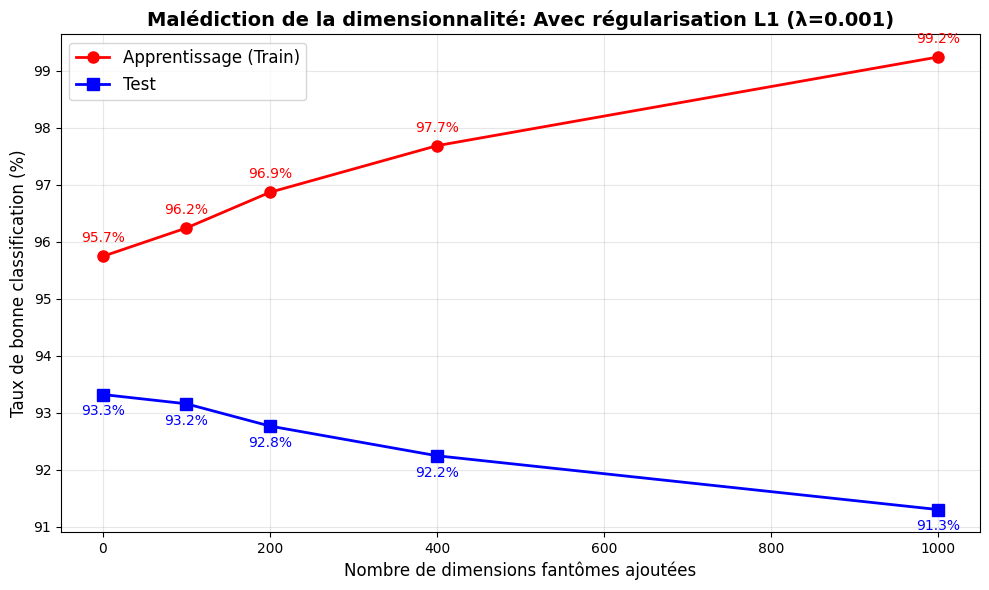

([np.float64(95.7457055707176),
  np.float64(96.24337774923744),
  np.float64(96.86948145769787),
  np.float64(97.68823246106919),
  np.float64(99.24546476159897)],
 [np.float64(93.32029977191267),
  np.float64(93.15738025415445),
  np.float64(92.7663734115347),
  np.float64(92.24503095470837),
  np.float64(91.30009775171065)])

In [23]:
tme9.dimensionality_curse_regul(X,Y, Xt, Yt, type='l1', llamdba=0.001)

=== DIMENSIONALITÉ FANTÔME - AVEC RÉGULARISATION L2 (λ=0.001) ===
Noise 0 ‑ Tx de bonne classification en App = 97.06 %
Noise 0 ‑ Tx de bonne classification en Test = 93.97 %
Noise 100 ‑ Tx de bonne classification en App = 98.36 %
Noise 100 ‑ Tx de bonne classification en Test = 92.44 %
Noise 200 ‑ Tx de bonne classification en App = 99.37 %
Noise 200 ‑ Tx de bonne classification en Test = 91.56 %
Noise 400 ‑ Tx de bonne classification en App = 99.98 %
Noise 400 ‑ Tx de bonne classification en Test = 90.68 %
Noise 1000 ‑ Tx de bonne classification en App = 100.00 %
Noise 1000 ‑ Tx de bonne classification en Test = 88.37 %


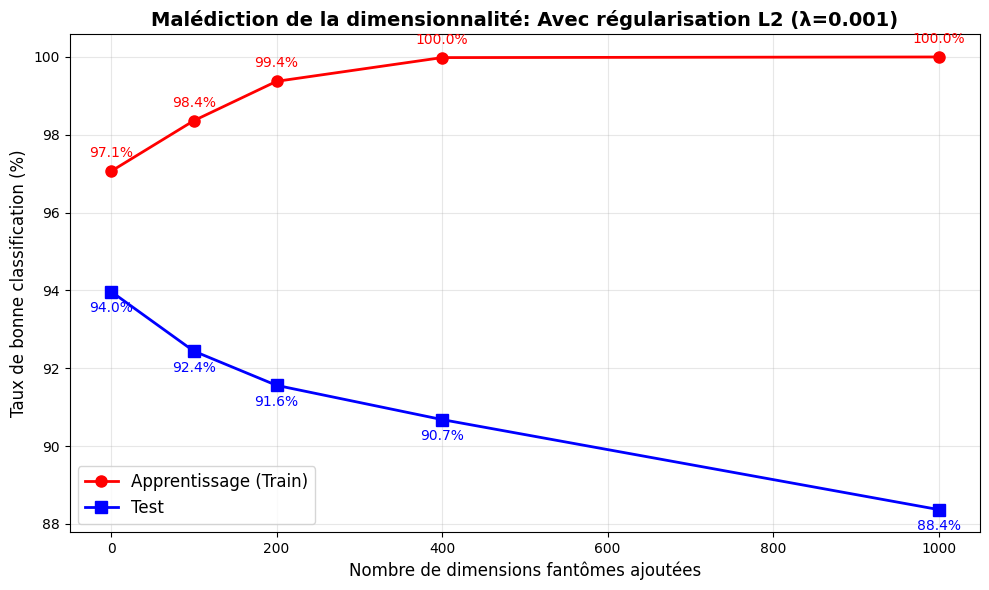

([np.float64(97.06212875260877),
  np.float64(98.36249799325735),
  np.float64(99.37389629153958),
  np.float64(99.98394605875743),
  np.float64(100.0)],
 [np.float64(93.97197784294559),
  np.float64(92.44053437601825),
  np.float64(91.56076898012383),
  np.float64(90.68100358422939),
  np.float64(88.36754643206255)])

In [24]:
tme9.dimensionality_curse_regul(X,Y, Xt, Yt, type='l2', llamdba=0.001)

# Exercice 7: et par rapport aux méthodes discriminantes à base de fonctions de cout?

Tester l'algorithme du perceptron vu en cours, avec l'astuce du un-contre-tous pour le passage au multi-classes.
Attention, pour le perceptron, le codage des deux classes est en $\{-1, 1\}$

Exercice 7: Test de l'algorithme Perceptron

1. Test du Perceptron binaire (classe 0 contre toutes)
Entraînement du Perceptron binaire pour reconnaître le chiffre 0...
Époque 0: erreurs = 231
Précision en apprentissage: 99.44%
Précision en test: 98.27%


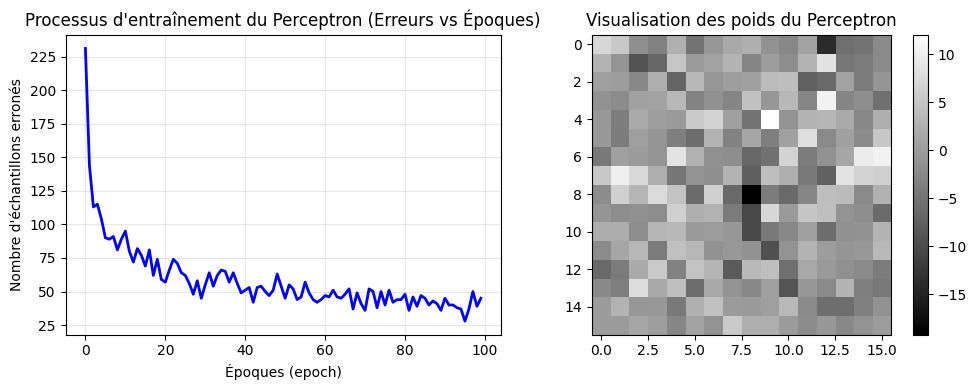


2. Test du Perceptron multiclasse (stratégie un contre tous)
Début de l'entraînement du Perceptron multiclasse...
Entraînement du Perceptron multi-classes (stratégie un-contre-tous)
Nombre de classes: 10
Nombre de données: 6229

Entraînement du classifieur pour la classe 0...
  Classe 0: accuracy = 99.37%, poids non-nuls = 256/256

Entraînement du classifieur pour la classe 1...
  Classe 1: accuracy = 99.65%, poids non-nuls = 253/256

Entraînement du classifieur pour la classe 2...
  Classe 2: accuracy = 97.56%, poids non-nuls = 256/256

Entraînement du classifieur pour la classe 3...
  Classe 3: accuracy = 98.25%, poids non-nuls = 256/256

Entraînement du classifieur pour la classe 4...
  Classe 4: accuracy = 98.65%, poids non-nuls = 256/256

Entraînement du classifieur pour la classe 5...
  Classe 5: accuracy = 99.21%, poids non-nuls = 256/256

Entraînement du classifieur pour la classe 6...
  Classe 6: accuracy = 99.52%, poids non-nuls = 256/256

Entraînement du classifieur pour la

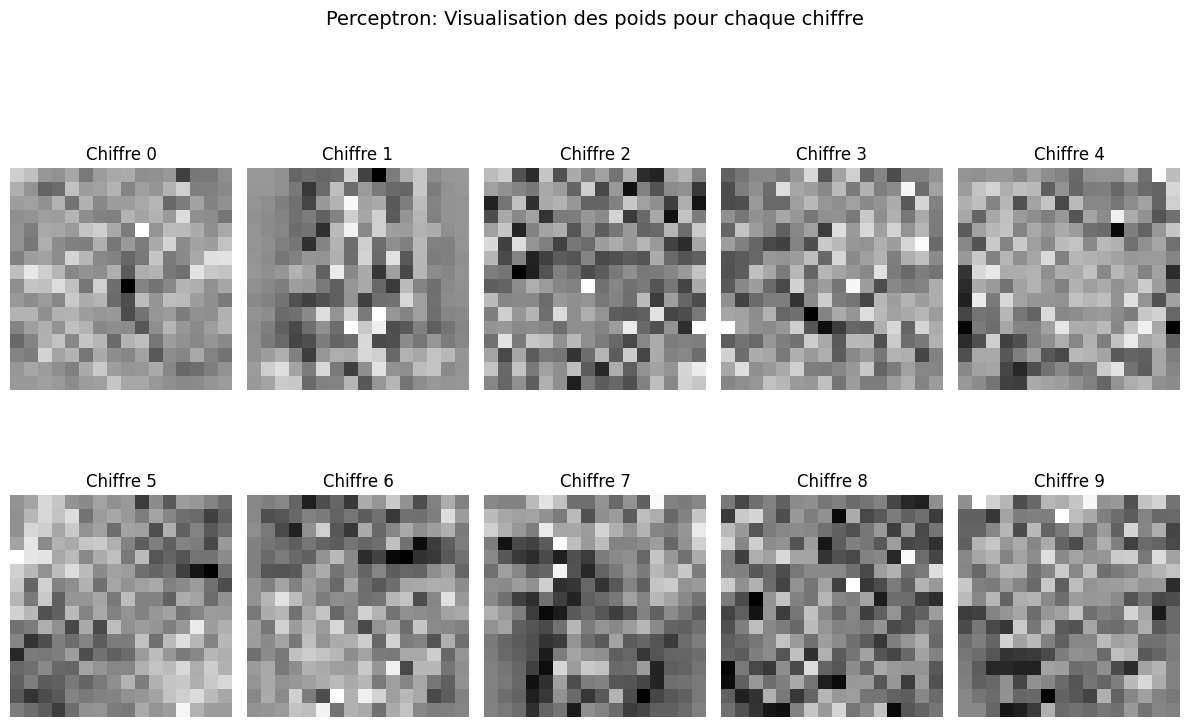


4. Analyse des échantillons mal classés
Nombre d'erreurs de classification en test: 258/3069 (8.41%)

Affichage des 5 premières erreurs de classification:


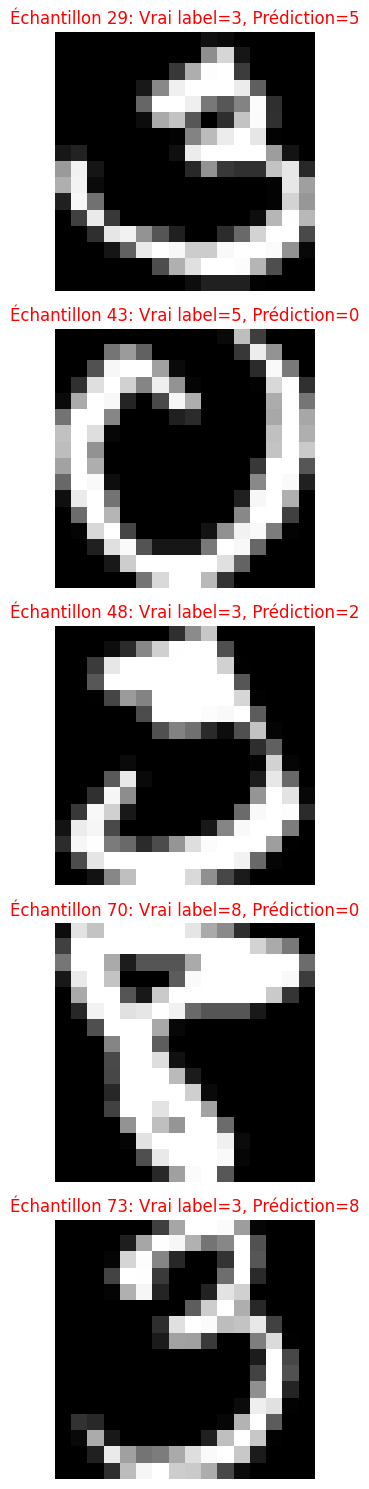


Types d'erreurs les plus fréquents:
  3→5: 17 fois
  4→2: 17 fois
  8→2: 14 fois
  3→2: 12 fois
  3→8: 11 fois
  4→9: 10 fois
  5→0: 8 fois
  9→7: 8 fois
  8→0: 7 fois
  4→8: 7 fois

5. Comparaison des performances: Perceptron vs Régression logistique
Entraînement de la régression logistique comme référence...

Tableau de comparaison des performances:
--------------------------------------------------
Méthode              Précision Apprentissage Précision Test 
--------------------------------------------------
Perceptron           96.77           91.59          
Régression logistique 96.07           93.87          
--------------------------------------------------


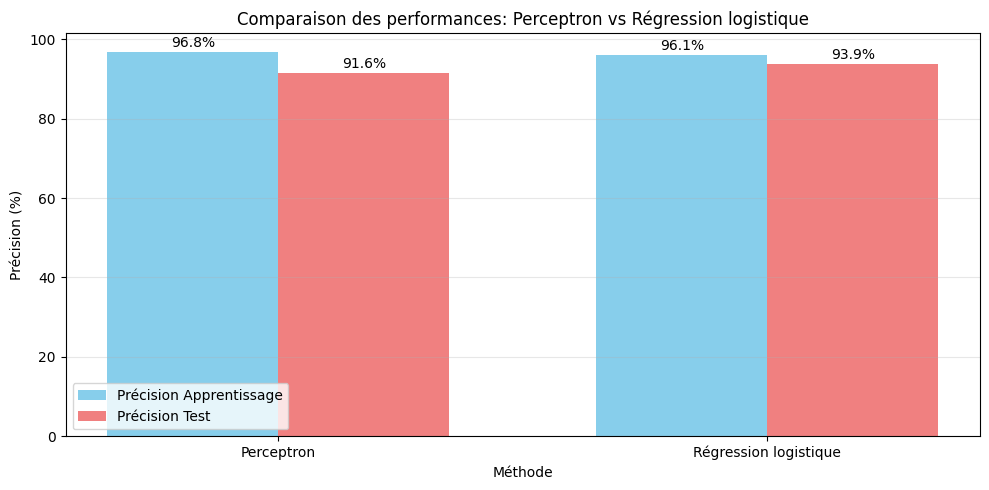

In [25]:
# ============================
# Exercice 7: Test de l'algorithme Perceptron
# ============================

print("=" * 60)
print("Exercice 7: Test de l'algorithme Perceptron")
print("=" * 60)

# -----------------------------------------------------------------
# 1. Test du Perceptron binaire (un chiffre contre tous)
# -----------------------------------------------------------------
print("\n1. Test du Perceptron binaire (classe 0 contre toutes)")

# Conversion des labels en binaire {0, 1} → {-1, 1}
classe_cible = 0
Y_bin_apprentissage = np.where(Y == classe_cible, 1, -1)  # Classe 0: 1, autres: -1
Y_bin_test = np.where(Yt == classe_cible, 1, -1)

# Entraînement du Perceptron binaire
print(f"Entraînement du Perceptron binaire pour reconnaître le chiffre {classe_cible}...")
w, b, historique = tme9.perceptron_binaire(
    X, Y_bin_apprentissage, 
    eta=0.1,          # Taux d'apprentissage
    epochs=100,       # Nombre d'époques
    verbose=1         # Affichage de la progression
)

# Visualisation du processus d'entraînement
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(historique, 'b-', linewidth=2)
plt.xlabel('Époques (epoch)')
plt.ylabel('Nombre d\'échantillons erronés')
plt.title('Processus d\'entraînement du Perceptron (Erreurs vs Époques)')
plt.grid(True, alpha=0.3)

# Prédictions sur l'ensemble d'apprentissage
predictions_apprentissage = np.sign(X @ w + b)
precision_apprentissage = np.mean(predictions_apprentissage == Y_bin_apprentissage) * 100

# Prédictions sur l'ensemble de test
predictions_test = np.sign(Xt @ w + b)
precision_test = np.mean(predictions_test == Y_bin_test) * 100

print(f"Précision en apprentissage: {precision_apprentissage:.2f}%")
print(f"Précision en test: {precision_test:.2f}%")

# Visualisation du vecteur de poids
plt.subplot(1, 2, 2)
if len(w) == 256:
    plt.imshow(w.reshape(16, 16), cmap='gray')
    plt.colorbar()
    plt.title('Visualisation des poids du Perceptron')
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------
# 2. Test du Perceptron multiclasse (stratégie un contre tous)
# -----------------------------------------------------------------
print("\n2. Test du Perceptron multiclasse (stratégie un contre tous)")

print("Début de l'entraînement du Perceptron multiclasse...")
W_perceptron, B_perceptron, historiques = tme9.perceptron_one_against_all(
    X, Y,
    eta=0.1,      # Taux d'apprentissage
    epochs=50,    # Nombre d'époques par classe
    verbose=1     # Affichage des informations détaillées
)

# Prédictions sur l'ensemble d'apprentissage
predictions_apprentissage_multi, scores_apprentissage = tme9.predict_perceptron_one_against_all(X, W_perceptron, B_perceptron)
precision_apprentissage_multi = tme9.accuracy(predictions_apprentissage_multi, Y) * 100

# Prédictions sur l'ensemble de test
predictions_test_multi, scores_test = tme9.predict_perceptron_one_against_all(Xt, W_perceptron, B_perceptron)
precision_test_multi = tme9.accuracy(predictions_test_multi, Yt) * 100

print(f"\nRésultats du Perceptron multiclasse:")
print(f"Précision en apprentissage: {precision_apprentissage_multi:.2f}%")
print(f"Précision en test: {precision_test_multi:.2f}%")

# -----------------------------------------------------------------
# 3. Visualisation des poids pour chaque classe
# -----------------------------------------------------------------
print("\n3. Visualisation des poids du Perceptron pour chaque classe")

plt.figure(figsize=(12, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    if W_perceptron.shape[0] == 256:
        plt.imshow(W_perceptron[:, i].reshape(16, 16), cmap='gray')
    plt.title(f"Chiffre {i}")
    plt.axis('off')
plt.suptitle('Perceptron: Visualisation des poids pour chaque chiffre', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------
# 4. Analyse des échantillons mal classés
# -----------------------------------------------------------------
print("\n4. Analyse des échantillons mal classés")

# Identification des échantillons mal classés dans le test
indices_erreurs = np.where(predictions_test_multi != Yt)[0]
nombre_erreurs = len(indices_erreurs)

print(f"Nombre d'erreurs de classification en test: {nombre_erreurs}/{len(Yt)} ({nombre_erreurs/len(Yt)*100:.2f}%)")

if nombre_erreurs > 0:
    # Affichage des premiers échantillons mal classés
    nombre_a_afficher = min(5, nombre_erreurs)
    print(f"\nAffichage des {nombre_a_afficher} premières erreurs de classification:")
    
    plt.figure(figsize=(15, 3 * nombre_a_afficher))
    for i, idx in enumerate(indices_erreurs[:nombre_a_afficher]):
        vrai_label = Yt[idx]
        label_prediction = predictions_test_multi[idx]
        
        plt.subplot(nombre_a_afficher, 1, i + 1)
        plt.imshow(Xt[idx].reshape(16, 16), cmap='gray')
        plt.title(f"Échantillon {idx}: Vrai label={vrai_label}, Prédiction={label_prediction}", 
                 color='red' if vrai_label != label_prediction else 'green')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Analyse des types d'erreurs les plus fréquents
    print("\nTypes d'erreurs les plus fréquents:")
    compteurs_erreurs = {}
    for idx in indices_erreurs:
        vrai_label = Yt[idx]
        label_prediction = predictions_test_multi[idx]
        type_erreur = f"{vrai_label}→{label_prediction}"
        compteurs_erreurs[type_erreur] = compteurs_erreurs.get(type_erreur, 0) + 1
    
    # Tri par fréquence décroissante
    erreurs_triees = sorted(compteurs_erreurs.items(), key=lambda x: x[1], reverse=True)
    for type_erreur, compte in erreurs_triees[:10]:
        print(f"  {type_erreur}: {compte} fois")

# -----------------------------------------------------------------
# 5. Comparaison des performances: Perceptron vs Régression logistique
# -----------------------------------------------------------------
print("\n5. Comparaison des performances: Perceptron vs Régression logistique")

# Ré-entraînement de la régression logistique comme référence (avec les fonctions précédentes)
print("Entraînement de la régression logistique comme référence...")
W_rl, B_rl = tme9.rl_gradient_ascent_multi_class_batch(
    X, Y, tbatch=500, eta=0.2, numEp=50, verbose=0
)

# Prédictions de la régression logistique
predictions_apprentissage_rl = tme9.classif_multi_class(tme9.pred_lr_multi_class(X, W_rl, B_rl))
predictions_test_rl = tme9.classif_multi_class(tme9.pred_lr_multi_class(Xt, W_rl, B_rl))

precision_apprentissage_rl = tme9.accuracy(predictions_apprentissage_rl, Y) * 100
precision_test_rl = tme9.accuracy(predictions_test_rl, Yt) * 100

print("\nTableau de comparaison des performances:")
print("-" * 50)
print(f"{'Méthode':<20} {'Précision Apprentissage':<15} {'Précision Test':<15}")
print("-" * 50)
print(f"{'Perceptron':<20} {precision_apprentissage_multi:<15.2f} {precision_test_multi:<15.2f}")
print(f"{'Régression logistique':<20} {precision_apprentissage_rl:<15.2f} {precision_test_rl:<15.2f}")
print("-" * 50)

# Visualisation comparative
plt.figure(figsize=(10, 5))
methodes = ['Perceptron', 'Régression logistique']
precisions_apprentissage = [precision_apprentissage_multi, precision_apprentissage_rl]
precisions_test = [precision_test_multi, precision_test_rl]

x = np.arange(len(methodes))
largeur = 0.35

plt.bar(x - largeur/2, precisions_apprentissage, largeur, label='Précision Apprentissage', color='skyblue')
plt.bar(x + largeur/2, precisions_test, largeur, label='Précision Test', color='lightcoral')

plt.xlabel('Méthode')
plt.ylabel('Précision (%)')
plt.title('Comparaison des performances: Perceptron vs Régression logistique')
plt.xticks(x, methodes)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Ajout des valeurs sur les barres
for i, (apprentissage, test) in enumerate(zip(precisions_apprentissage, precisions_test)):
    plt.text(i - largeur/2, apprentissage + 0.5, f'{apprentissage:.1f}%', ha='center', va='bottom')
    plt.text(i + largeur/2, test + 0.5, f'{test:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()